In [2]:
import sys
sys.path.append('..')

import h5py
from proSVD import proSVD
import numpy as np
import matplotlib.pyplot as plt
import pdb
from utils.utils import *
from models.data_manager import DataManager

In [14]:
input_dir = '/home/sachinks/Data/processed/mouse-cshl'
cam = '1'

##################################
def load_input_data(dir):
    h5_path = f'{dir}/cam{cam}.h5'

    # Open the HDF5 file and extract the data
    with h5py.File(h5_path, 'r') as hf:
        data = hf['data'][:]

    # Convert data to uint8 (assuming grayscale images)
    data = (data).astype('uint8')
    return data

##################################

data = load_input_data(input_dir)


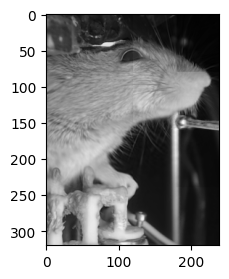

In [12]:
plt.figure(figsize=(3, 3))
plt.imshow(data[0], cmap='gray')

In [13]:
PROSVD_K = 4 # no. of dims to reduce to
PROSVD_INIT_FRAME = 100 # No of initial frames used to initialize proSVD

video_metadata = {
    'shape': None,
    'fps': None
}

dm = DataManager()

In [16]:
##################################
def compute_prosvd():
    generator = stream_numpy_array(data)

    frames = []  # for proSVD initialization

    # Iterate over the generator and process each batch
    for index, frame in enumerate(generator):
        frame = frame[0]

        if index == 0:
            video_metadata['shape'] = frame.shape

        frame = frame.flatten()

        if index < PROSVD_INIT_FRAME:
            frames.append(frame)
            continue

        if index == PROSVD_INIT_FRAME:
            frames = np.array(frames).T
            pro = proSVD(k=PROSVD_K, w_len=1,history=0, decay_alpha=1, trueSVD=True)
            pro.initialize(frames)

        pro.preupdate()
        pro.updateSVD(frame[:, None])
        pro.postupdate()

        dm.add('Q', pro.Q)
##################################

compute_prosvd()

Saving proSVD outputs

In [18]:
output_dir = '/home/sachinks/Data/output/mouse-cshl'
output_dir = f'{output_dir}/cam{cam}'
dm.save(output_dir)

Visualization of proSVD

In [33]:
Q = dm.get('Q')[0]
frame_shape = video_metadata['shape']
Q_ = Q.reshape(frame_shape[0], frame_shape[1], PROSVD_K)
Q_.shape

(320, 240, 4)

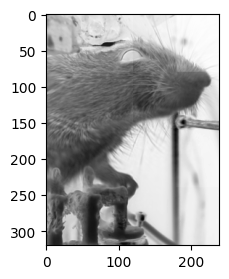

In [60]:
Q = dm.get('Q')
frame_shape = video_metadata['shape']
i = 0
Qi = Q[i]
Qi = Qi.reshape(frame_shape[0], frame_shape[1], PROSVD_K)
plt.figure(figsize=(3, 3))
plt.imshow(Qi[..., 0], cmap='gray')
plt.show()

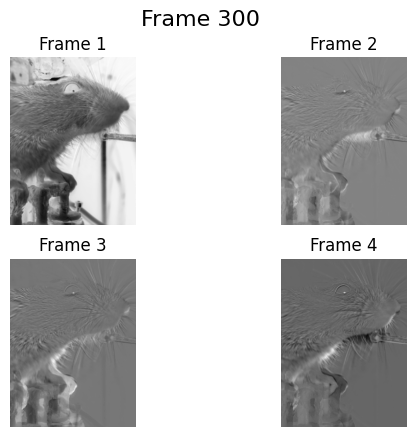

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import islice


Q = dm.get('Q')
frame_shape = video_metadata['shape']

# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2)

# Initialize empty plots for the first frames
images = []

Q0 = Q[0]
Q0 = Q0.reshape(frame_shape[0], frame_shape[1], PROSVD_K)
for i in range(4):
    ax = axs[i // 2, i % 2]
    im = ax.imshow(Q0[..., i], cmap='gray')
    images.append(im)
    ax.set_title(f"Frame {i+1}")  # Add titles to each subplot
    ax.axis('off')

# Super-title for the whole figure
suptitle = plt.suptitle('Frame 1', fontsize=16, y=0.98)  # Initial frame number

# Function to update the plots with each new frame
def update(frame_idx):
    Qi = Q[frame_idx]
    Qi = Qi.reshape(frame_shape[0], frame_shape[1], PROSVD_K)
    for j in range(4):
        images[j].set_array(Qi[..., j])
    suptitle.set_text(f'Frame {frame_idx + 1}')
    return images

# Create the animation
ani = FuncAnimation(fig, update, frames=300, interval=100, repeat=False)

# Save the animation as a GIF (optional)
ani.save('animation.gif', writer='pillow', fps=30)

# Show the animation (displaying it in Jupyter Notebook or an interactive environment)
plt.show()

Analysis

In [62]:
data = dm.load(output_dir, ['Q'])
Q_full = data['Q']
Q_diff = np.diff(Q_full, axis=0)
Q_norm_diff = np.linalg.norm(Q_diff, axis=1)
Q_norm_diff = np.insert(Q_norm_diff, 0, 0, axis=0)

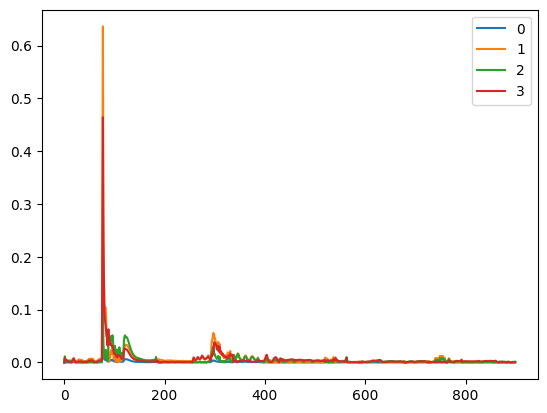

In [63]:
for i in range(PROSVD_K):
    plt.plot(Q_norm_diff[:, i], label=i)
plt.legend()
plt.show()